<a href="https://colab.research.google.com/github/CodeArtificial/Facial-Recognition-AlexNet-ResNet-ViT/blob/main/Facial_Recognition_Hyperparameter_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm
from PIL import Image

In [ ]:
img_row, img_col = 48, 48
classes = 7

In [ ]:
class_names = {'0': 'Angry', 
            '1': 'Disgust', 
            '2': 'Fear', 
            '3':'Happy', 
            '4': 'Sad', 
            '5': 'Surprise', 
            '6': 'Neutral',
            0: 'Angry', 
            1: 'Disgust', 
            2: 'Fear', 
            3:'Happy', 
            4: 'Sad', 
            5: 'Surprise', 
            6: 'Neutral'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Spring_2022/CS389/final/archive.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('data/')
  print('Done')

Done


In [ ]:
train_dir = 'data/train/'
test_dir = 'data/test/'

In [ ]:
def load_dataset(batch_size):
    to_tensor_transform = torchvision.transforms.Compose([tt.Grayscale(num_output_channels=1),
                                     tt.ToTensor()])

    train_dataset = ImageFolder(root=train_dir, transform=to_tensor_transform)
    train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = ImageFolder(root=test_dir, transform=to_tensor_transform)
    test_dataset_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    return train_dataset, train_dataset_loader, test_dataset, test_dataset_loader

In [ ]:
def plot_image_and_label(image, label):
    
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''

    image = image.reshape(1, 48,48)

    plt.imshow(image[0])

    if type(label) is not int:
        _,predicted = torch.max(label,1)
        plt.title("Best label = " + class_names[str(predicted.item())] + ", with Score: " + str(round(label[0][predicted].item() * 100,2)))
    else:
        plt.title("Label = " + class_names[str(label)])
    plt.show()
    return

torch.Size([1, 48, 48])


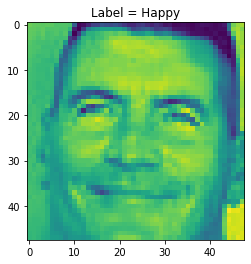

In [ ]:
train_dataset, train_dataset_loader, test_dataset, test_dataset_loader = load_dataset(batch_size=32)
ex_image, ex_label = train_dataset[random.randint(10000,20000)]
print(ex_image.shape)
plot_image_and_label(ex_image, ex_label)

In [ ]:
class FERNet(nn.Module):
    """
    This will be the CNN model that will classify facial expressions
    """
    def __init__(self, input_size, classes=7):
        super().__init__()
        #Initialize the CNN network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=0, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=0, stride=1)
        self.conv3 = nn.Conv2d(64, 256, kernel_size=(3,3), padding=0, stride=1)
        self.relu = nn.ReLU()
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.batchNorm2 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(kernel_size=1, stride=(1,1))
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(196*48*48, 64)
        self.lin2 = nn.Linear(64, classes)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):

        x = x.view(-1, 1, 48, 48).float() 
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.batchNorm1(out)
        out = self.maxpool(out)
        out = self.dropout1(out)

        out = self.conv3(out)
        out = self.batchNorm2(out)
        out = self.maxpool(out)
        out = self.dropout1(out)

        out = self.flatten(out)
        out = self.lin1(out)
        out = self.relu(out)
        out = self.dropout2(out)

        out = self.lin2(out)
        out = self.softmax(out)

        return out

In [ ]:
# test_model = FERNet(48*48, 7)
# ex_image, ex_label = train_dataset[random.randint(10000,20000)]
# test_output = test_model(ex_image)
# plot_image_and_label(ex_image.reshape(48,48), test_output)

In [ ]:
# model = FERNet(48*48, 7)

# loss_function = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean');                    
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001);

# print("BEFORE GRADIENT STEP:")
# ex_pred = model(ex_image.flatten())
# print("prediction:",ex_pred)
# mod_ex_label = torch.Tensor([ex_label]).long()
# print("label:",mod_ex_label)

# optimizer.zero_grad() # Sets the gradient to 0 so that gradients don't stack together

# ex_loss1 = loss_function(ex_pred, mod_ex_label)
# print("loss",ex_loss1.item())

# ex_loss1.backward() # This gets the gradient of the loss function w.r.t all of your model's params

# print()
# print("AFTER GRADIENT STEP:")
# optimizer.step() # This takes the step to train

# ex_pred = model(ex_image.flatten())
# print("prediction:",ex_pred)
# print("label:",mod_ex_label)

# ex_loss2 = loss_function(ex_pred, mod_ex_label)
# print("loss",ex_loss2.item())

# print()
# print("Difference in loss:", (ex_loss1 - ex_loss2).item())
# print("This should be some positive number to say we reduced loss")

In [ ]:

def saveCheckpoint(epoch, model, optimizer, loss):
  CNN_FERNET_MODEL_STATE = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optmizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
  }
  torch.save(CNN_FERNET_MODEL_STATE, '/content/drive/MyDrive/Spring_2022/CS389/final/cnn_fernet_model.pt')
  return

In [ ]:
# saveCheckpoint(1, model, optimizer, ex_loss2)

In [ ]:
def cnn_training(model, loss_function, optimizer, train_data, n_epochs, c_epoch, update_interval):
    
    losses = []
    loss = 0

    for n in range(n_epochs - c_epoch):
        mLoss = []
        minLoss = 1000
        for i, (image, label) in enumerate(tqdm(train_data)):

            image = image.float().view(-1,1,48,48)
            ##############################################################

            prediction = model(image)
            optimizer.zero_grad() # Sets the gradient to 0 so that gradients don't stack together
            loss = loss_function(prediction, label.long())
            loss.backward() # This gets the gradient of the loss function w.r.t all of your model's params
            optimizer.step() # This takes the step to train

            ##############################################################
            if (loss.item() < minLoss):
              minLoss = loss.item()
              CNN_FERNET_MODEL_STATE = {
                'epoch': n + c_epoch + 1,
                'model_state_dict': model.state_dict(),
                'optmizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
              }
              torch.save(CNN_FERNET_MODEL_STATE, '/content/drive/MyDrive/Spring_2022/CS389/final/cnn_fernet_model_min.pt')

            mLoss.append(loss.item())
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss

        saveCheckpoint(n + c_epoch + 1, model, optimizer, loss)
        print("epoch: ", n + c_epoch + 1)
        print("loss: ", np.mean(mLoss))
        
    return model, losses

In [ ]:
# """
# INCLUDE LOSSES ARRAY TO THE CHECKPOINT 
# """
# import math
# def saveCheckpointHyper(model, optimizer):
#   CNN_FERNET_MODEL_HYPER_STATE = {
#     'epoch': 1,
#     'learning_rate': 0,
#     'update_interval': 50,
#     'batch_size': 32,
#     'model_state_dict': model.state_dict(),
#     'optmizer_state_dict': optimizer.state_dict(),
#     'loss': math.inf,
#   }
#   torch.save(CNN_FERNET_MODEL_HYPER_STATE, '/content/drive/MyDrive/Spring_2022/CS389/final/cnn_fernet_model_hyper_searched.pt')
#   return

In [ ]:
# saveCheckpointHyper(model, optimizer)

In [ ]:
import math
def hyperparam_random_search():
  learning_rate_out = None
  batch_size_out = None
  update_interval_out = None
  n_epochs_out = None


  loss_function = nn.CrossEntropyLoss()

  # Load saved checkpoint
  model = FERNet (48 * 48, 7)
  model_saved = torch.load('/content/drive/MyDrive/Spring_2022/CS389/final/cnn_fernet_model_hyper_searched.pt')
  print("Model's Checkpoint Loaded")
  model.load_state_dict(model_saved['model_state_dict'])

  if math.isinf(np.mean(model_saved['loss'])):
    curr_loss = math.inf
  else:
    curr_loss = np.mean(model_saved['loss'])
  curr_model = None

  print("Model's Checkpoint epoch: ", model_saved['epoch'])
  print("Model's Checkpoint learning rate: ", model_saved['learning_rate'])
  print("Model's Checkpoint update interval: ", model_saved['update_interval'])
  print("Model's Checkpoint batch size: ", model_saved['batch_size'])
  print("Model's Checkpoint loss: ", curr_loss)

  # random search of for hyperparmeters
  for learning_rate in [1e-10, 1e-8, 1e-6, 1e-4]:
    # for batch_size in range(model_saved['batch_size'], 100, 10):
      # for update_interval in range(model_saved['update_interval'], 100, 10):
        for n_epochs in range(1, 11):

          # Trained our model
          optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
          optimizer.load_state_dict(model_saved['optmizer_state_dict'])
          test_model, test_loss = cnn_training(model, loss_function, optimizer, train_dataset_loader, n_epochs=n_epochs, c_epoch=model_saved['epoch'], update_interval=50)

          t_loss = np.mean(test_loss)

          #If loss is lower than the previous
          if t_loss < curr_loss:

            # Mark the new model and loss
            curr_loss = t_loss
            curr_model = test_model

            # Mark the new hyperparameters
            learning_rate_out = learning_rate
            # batch_size_out = batch_size
            # update_interval_out = update_interval
            n_epochs_out = n_epochs

            # Saved the new model with new hyperparameters
            CNN_FERNET_MODEL_STATE_HYPER = {
                'epoch': n_epochs_out,
                'learning_rate': learning_rate_out,
                'update_interval': 50,
                'batch_size': 32,
                'model_state_dict': model.state_dict(),
                'optmizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
              }
            torch.save(CNN_FERNET_MODEL_STATE_HYPER, '/content/drive/MyDrive/Spring_2022/CS389/final/cnn_fernet_model_hyper_searched.pt')

            print("New epoch: ", n_epochs_out)
            print("New learning_rate: ", learning_rate_out)
            print("New loss: ", t_loss)


            # Display graphs  
            plt.plot(np.arange(len(test_loss)) * 32 * 50, test_loss)
            plt.title("training curve")
            plt.xlabel("number of images trained on")
            plt.ylabel("loss") 
            plt.show()

  return curr_loss, curr_model


# New Section

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model's Checkpoint Loaded
Model's Checkpoint epoch:  9
Model's Checkpoint learning rate:  0.0001
Model's Checkpoint update interval:  50
Model's Checkpoint batch size:  32
Model's Checkpoint loss:  1.6522222222222223


100%|██████████| 898/898 [28:41<00:00,  1.92s/it]


epoch:  10
loss:  1.6651597208859925


100%|██████████| 898/898 [28:45<00:00,  1.92s/it]


epoch:  10
loss:  1.6636797437954587


100%|██████████| 898/898 [29:04<00:00,  1.94s/it]


epoch:  10
loss:  1.6608100526847924
New epoch:  10
New learning_rate:  1e-06
New loss:  1.6183333333333332


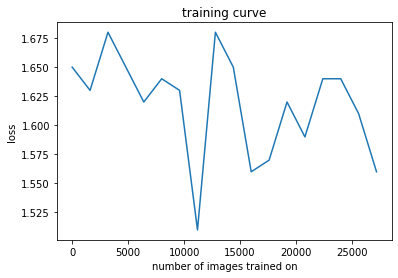

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 898/898 [29:07<00:00,  1.95s/it]


epoch:  10
loss:  1.6600460718097558


(1.6183333333333332, FERNet(
   (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
   (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
   (relu): ReLU()
   (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (batchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (dropout1): Dropout(p=0.25, inplace=False)
   (dropout2): Dropout(p=0.5, inplace=False)
   (maxpool): MaxPool2d(kernel_size=1, stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (lin1): Linear(in_features=451584, out_features=64, bias=True)
   (lin2): Linear(in_features=64, out_features=7, bias=True)
   (softmax): Softmax(dim=1)
 ))

In [ ]:
hyperparam_random_search()